In [1]:
# from autocvd import autocvd
# autocvd(num_gpus = 1)
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["JAX_PLATFORMS"] = "cpu"

import numpy as np
import matplotlib.pyplot as plt

import jax.random as jr

from unxt import Quantity
import galax.coordinates as gc
import galax.potential as gp
import galax.dynamics as gd

import agama

import time



In [2]:
# Fardal+15
pot = gp.BovyMWPotential2014()

w = gc.PhaseSpacePosition(q=Quantity([11.8, 0.79, 6.4], "kpc"),
                            p=Quantity([109.5,-254.5,-90.3], "km/s"),
                        )

t_array = Quantity(-np.arange(500+1)*6, "Myr")
prog_mass = Quantity(1e5, "Msun")

df = gd.FardalStreamDF()
gen = gd.MockStreamGenerator(df, pot)
%time stream_f15, _ = gen.run(jr.key(0), t_array, w, prog_mass)

CPU times: user 11 s, sys: 985 ms, total: 11.9 s
Wall time: 8.06 s


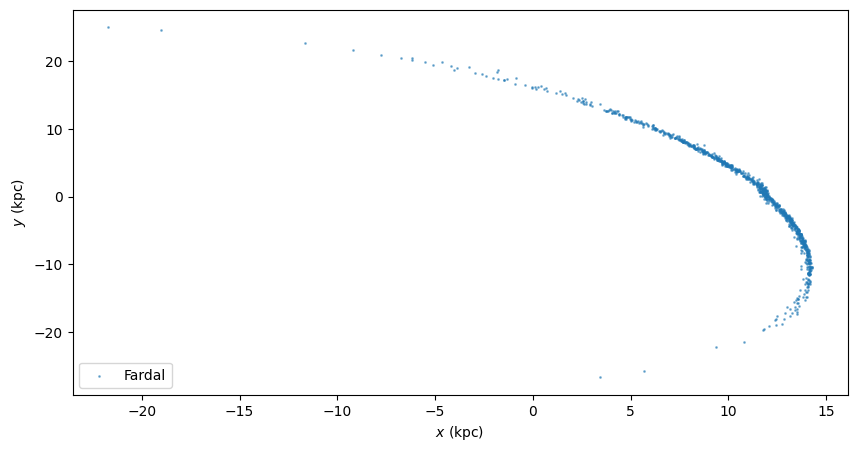

In [3]:
fig = plt.figure(figsize=(10, 5))
stream_c25, prog_c25 = gen.run(jr.key(0), t_array, w, prog_mass)
plt.scatter(stream_c25.q.x.value, stream_c25.q.y.value, s=1, label="Fardal", alpha=0.5)
plt.xlabel(r'$x\ ({\rm kpc})$')
plt.ylabel(r'$y\ ({\rm kpc})$')
plt.legend(loc='lower left')
# plt.savefig('./plot/particlespray_chen25/stream_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Agama

In [4]:
actFinder?


Object `actFinder` not found.


In [5]:
from astropy import units as u

1002


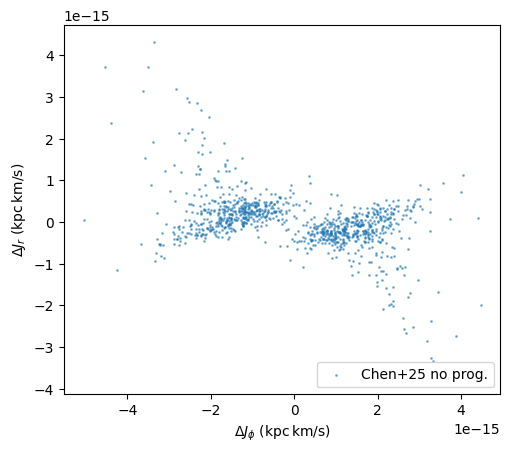

In [25]:
import agama # to calculate action
agama.setUnits(length=1, velocity=1, mass=1) # working units: 1 Msun, 1 kpc, 1 km/s

actFinder = agama.ActionFinder(agama.Potential('./MWPotential2024.ini'))


def get_action(stream, prog, actFinder):
    pos_prog = np.array([prog.q.x.to('kpc').value, prog.q.y.to('kpc').value, prog.q.z.to('kpc').value])
    vel_prog = np.array([prog.p.x.to('km/s').value, prog.p.y.to('km/s').value, prog.p.z.to('km/s').value])
    posvel_prog = np.r_[pos_prog.squeeze(),vel_prog.squeeze()]
    action_prog, angles_prog, freqs_prog = actFinder(posvel_prog, angles=True, )
    Jphi_prog = action_prog[2]
    Jr_prog = action_prog[0]

    pos = np.array([stream.q.x.to('kpc').value, stream.q.y.to('kpc').value, stream.q.z.to('kpc').value])
    vel = np.array([stream.p.x.to('km/s').value, stream.p.y.to('km/s').value, stream.p.z.to('km/s').value])
    posvel = np.column_stack((pos.T,vel.T))
    actions, angles, freqs = actFinder(posvel, angles=True, )
    print(len(actions))
    Jphi = actions[:,2]
    Jr = actions[:,0]
    last_J =actions[:, 1]
    
    # DLtot = Ltot - Ltot_prog
    DJphi = Jphi - Jphi_prog
    DJr = Jr - Jr_prog
    return DJphi, DJr, Jphi, Jr, last_J, Jphi_prog, Jr_prog, action_prog, actions, angles_prog, angles,freqs_prog, freqs
    
# DJphi, DJr = get_action(stream_f15, prog_f15, actFinder)
# plt.scatter(DJphi, DJr, s=1, alpha=0.5, label='Fardal+15')

DJphi, DJr, Jphi, Jr, last_J, Jphi_prog, Jr_prog, action_prog, actions, angles_prog, angles, freqs_prog, freqs = get_action(stream_c25, prog_c25, actFinder)
plt.figure()
plt.scatter(DJphi * (u.kpc * u.km / u.s).to(u.kpc**2/u.s), DJr * (u.kpc * u.km / u.s).to(u.kpc**2/u.s), s=1, alpha=0.5, label='Chen+25 no prog.')
plt.xlabel(r'$\Delta J_\phi\ ({\rm kpc\,km/s})$')
plt.ylabel(r'$\Delta J_r\ ({\rm kpc\,km/s})$')
# plt.xlim(-120, 120)
# plt.ylim(-100, 100)
plt.legend(loc='lower right')
plt.gca().set_aspect(1)
# plt.savefig('./plot/particlespray_chen25/stream_action_plot.png', dpi=300, bbox_inches='tight')
plt.show()



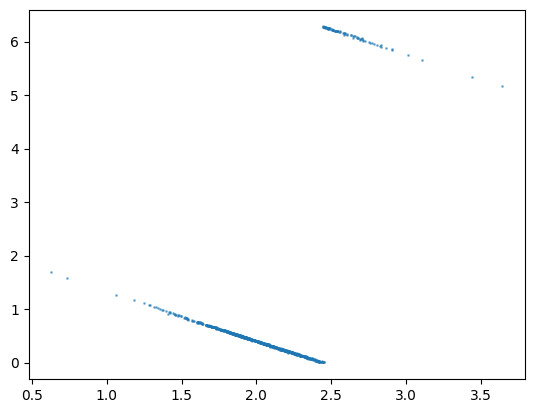

In [7]:
plt.scatter(angles[:,1], angles[:,2], s=1, alpha=0.5)

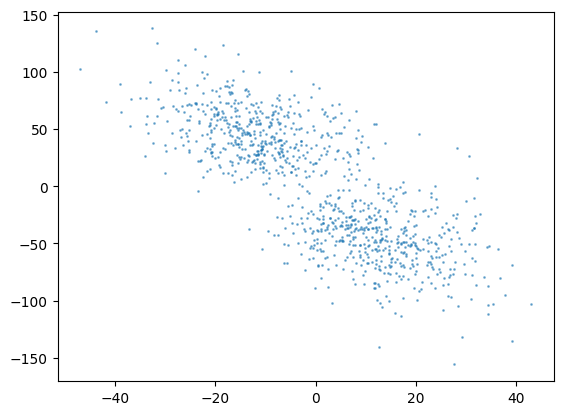

In [8]:
plt.scatter(actions[:,1]-action_prog[1], actions[:,2]-action_prog[2], s=1, alpha=0.5)

In [9]:
angles.shape

(1002, 3)

In [10]:
freqs.shape

(1002, 3)

In [11]:
angles_prog.shape

(3,)

In [12]:
angles_prog

array([0.11450058, 2.06683645, 0.33958026])

# No rotation 

In [26]:
angles[angles > np.pi ] = angles[angles > np.pi ] - 2 * np.pi
# angles[angles < -np.pi ] = angles[angles < -np.pi ] + 2 * np.pi

In [27]:
delta_angles = angles - angles_prog
# delta_angles = angles
delta_angles.shape


(1002, 3)

In [28]:
np.pi

3.141592653589793

In [29]:
angles_prog

array([0.11450058, 2.06683645, 0.33958026])

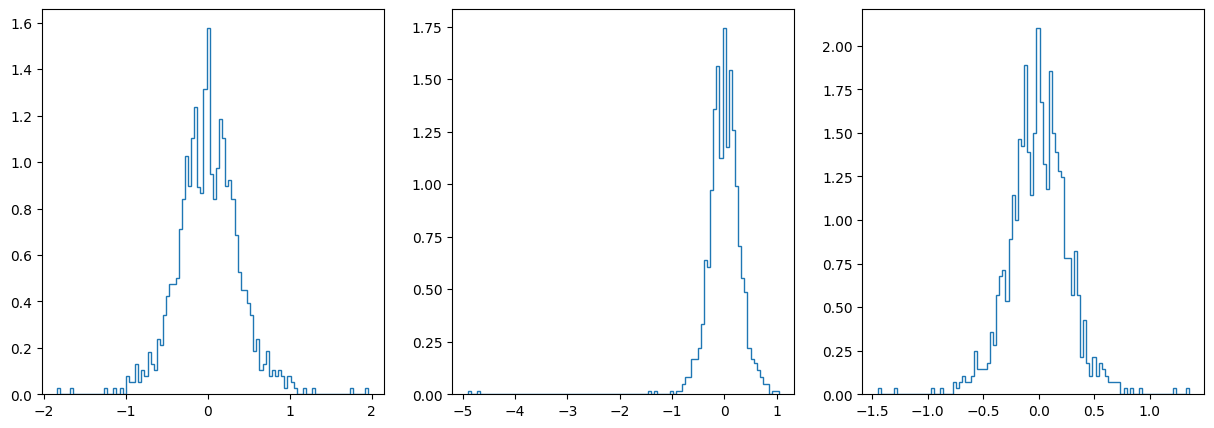

In [30]:
fig = plt.figure(figsize=(15, 5))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    ax.hist(delta_angles[:,i], bins=100, histtype='step', density=True)
    # ax.set_xlim(-1, 1)

delta_t:
[-6.59934569 -0.89418681  2.66345537 ...  0.01259219  0.01734761
  0.01670736]
delta_alpha shape:
(1002, 3)


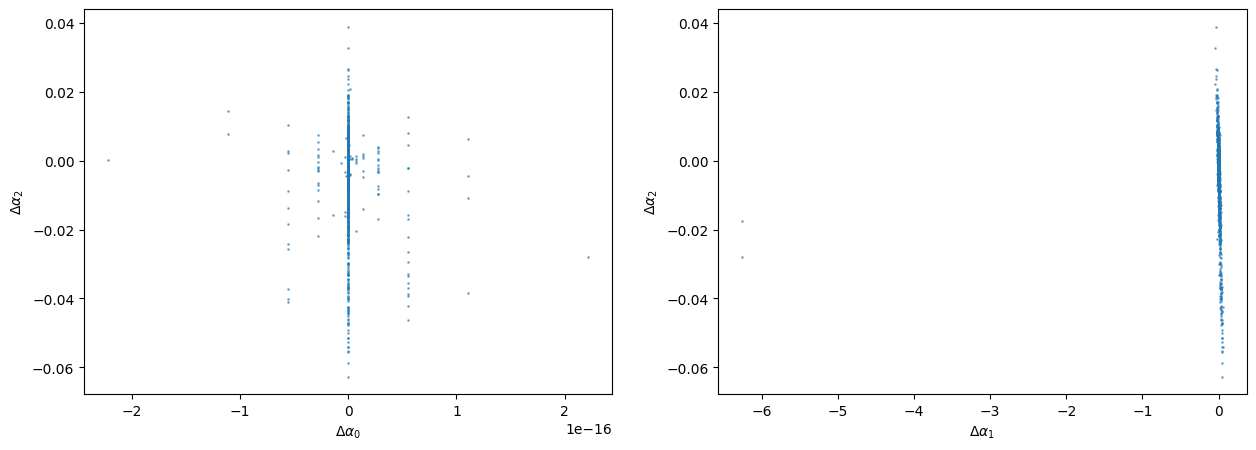

In [31]:
# I miss the rotation !


delta_angles = angles - angles_prog
delta_freqs = freqs - freqs_prog

# delta_t = np.linalg.norm(delta_angles, axis=1)/np.linalg.norm(delta_freqs, axis=1)
delta_t = delta_angles[:, 0]/delta_freqs[:, 0]
print('delta_t:')
print(delta_t)

delta_alpha = delta_angles - delta_freqs * delta_t[:, None]
print('delta_alpha shape:')
print(delta_alpha.shape)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121,)
ax.scatter(delta_alpha[:,0], delta_alpha[:,2], s=1, alpha=0.5)
ax.set_xlabel(r'$\Delta \alpha_0$')
ax.set_ylabel(r'$\Delta \alpha_2$')

ax = fig.add_subplot(122,)
ax.scatter(delta_alpha[:,1], delta_alpha[:,2], s=1, alpha=0.5)
ax.set_xlabel(r'$\Delta \alpha_1$')
ax.set_ylabel(r'$\Delta \alpha_2$')
plt.show() 


Text(0.5, 0, '$h = \\sqrt{\\Delta \\alpha_1^2 + \\Delta \\alpha_2^2}$')

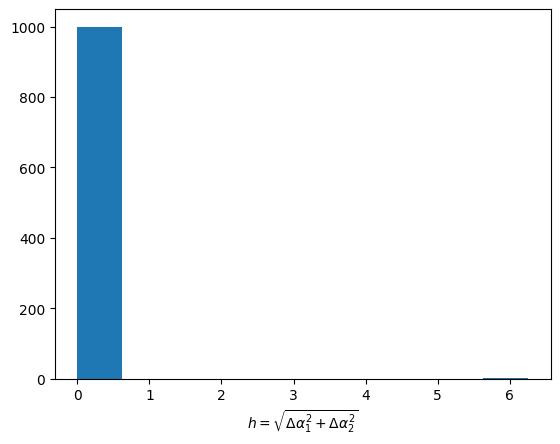

In [32]:
h = np.sqrt(delta_alpha[:, 1]**2 + delta_alpha[:, 2]**2)
plt.hist(h )
plt.xlabel(r'$h = \sqrt{\Delta \alpha_1^2 + \Delta \alpha_2^2}$')

In [33]:
d.argmax()

NameError: name 'd' is not defined

In [34]:
d.max()

NameError: name 'd' is not defined

In [35]:
delta_alpha[d.argmax()]

NameError: name 'd' is not defined

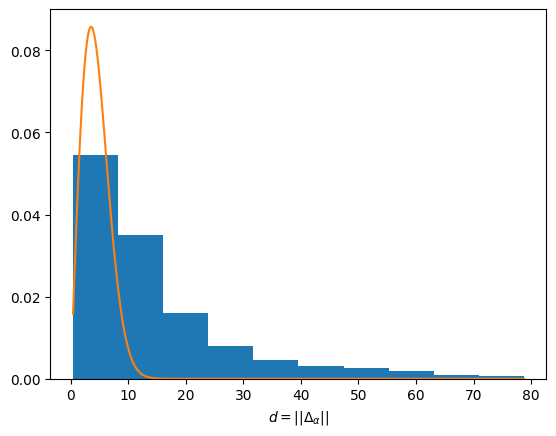

In [47]:
d = np.linalg.norm(delta_alpha * 1000, axis=1) 
d_plot = d[d<1000]
plt.hist(d_plot, density=True , bins=10);
plt.xlabel(r'$d = ||\Delta_\alpha||$')
x = np.sort(d_plot)
sigma = 5
plt.plot(x,  x/sigma**2 * np.exp(-x**2/sigma**2))
# plt.xlim(0, 0.1)

/tmp/ipykernel_2761449/633850117.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left')



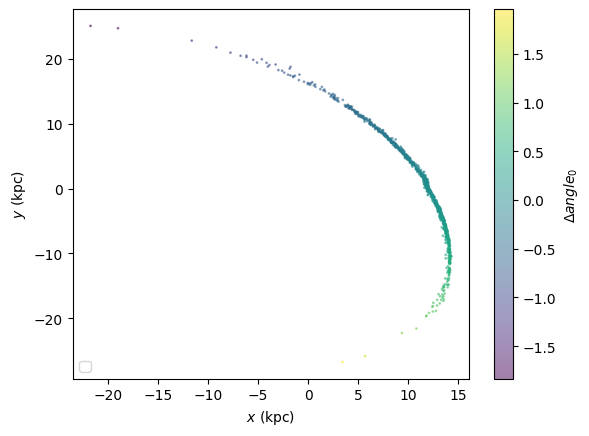

In [48]:
plt.scatter(stream_c25.q.x.value, stream_c25.q.y.value, s=1, c=(angles[:, 0] - angles_prog[0]), alpha=0.5)
plt.xlabel(r'$x\ ({\rm kpc})$')
plt.ylabel(r'$y\ ({\rm kpc})$')
plt.legend(loc='lower left')
plt.colorbar(label=r'$\Delta angle_0$')
# plt.savefig('./plot/particlespray_chen25/stream_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# With rotation

In [49]:
import numpy as np
from scipy.stats import differential_entropy
from scipy.optimize import minimize
from scipy.special import erfinv
def rotation_matrix(phi_r, phi_phi, phi_z):
    """Return combined rotation matrix R = Rr Rphi Rz."""
    cr, sr = np.cos(phi_r), np.sin(phi_r)
    cphi, sphi = np.cos(phi_phi), np.sin(phi_phi)
    cz, sz = np.cos(phi_z), np.sin(phi_z)

    Rr = np.array([[1, 0, 0],
                   [0, cr, -sr],
                   [0, sr, cr]])

    Rphi = np.array([[cphi, 0, sphi],
                     [0, 1, 0],
                     [-sphi, 0, cphi]])

    Rz = np.array([[cz, -sz, 0],
                   [sz, cz, 0],
                   [0, 0, 1]])

    return Rr @ Rphi @ Rz  # Equation (F1)


def entropy_objective(angles, dJ, dOmega):
    """Objective to minimize: sum of entropies h(φ | Λ_j)."""
    R = rotation_matrix(*angles)
    dJp = dJ @ R.T
    dOp = dOmega @ R.T

    # Avoid division issues
    mask = np.all(np.abs(dJp) > 1e-8, axis=1)
    dJp, dOp = dJp[mask], dOp[mask]

    Lambda = dOp / dJp  # shape (N, 3)
    entropies = [differential_entropy(Lambda[:, j]) for j in range(3)]
    return np.sum(entropies)


def estimate_hessian_rotation(J, Omega, J0=None, Omega0=None):
    """
    Estimate Hessian eigenvalues and rotation angles from an N-body stream.
    Based on Appendix F of the paper.
    """
    J = np.asarray(J)
    Omega = np.asarray(Omega)
    if J0 is None:
        J0 = np.median(J, axis=0)
    if Omega0 is None:
        Omega0 = np.median(Omega, axis=0)

    dJ = J - J0
    dOmega = Omega - Omega0

    # Minimize entropy sum over angles in [0, π/2)
    bounds = [(0, np.pi/2)] * 3
    res = minimize(entropy_objective, x0=[0.3, 0.3, 0.3],
                   args=(dJ, dOmega), bounds=bounds)

    phi_hat = res.x
    R_opt = rotation_matrix(*phi_hat)

    # Compute final ratios Λ_j and eigenvalue medians
    dJp = dJ @ R_opt.T
    dOp = dOmega @ R_opt.T
    Lambda = dOp / dJp

    lambda_hat = np.median(Lambda, axis=0)

    # Median Absolute Deviation as uncertainty
    c = 1 / (np.sqrt(2) * erfinv(0.5))
    mad = c * np.median(np.abs(Lambda - lambda_hat), axis=0)

    return {
        "phi_hat": phi_hat,
        "lambda_hat": lambda_hat,
        "mad": mad,
        "success": res.success,
        "message": res.message,
    }

result = estimate_hessian_rotation(J=actions, Omega=freqs, J0=action_prog, Omega0=freqs_prog)
result


{'phi_hat': array([0.23213888, 0.7471015 , 0.20488166]),
 'lambda_hat': array([ 0.00085811, -0.00953519, -0.00440512]),
 'mad': array([0.00045396, 0.00235776, 0.00107375]),
 'success': True,
 'message': 'CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH'}

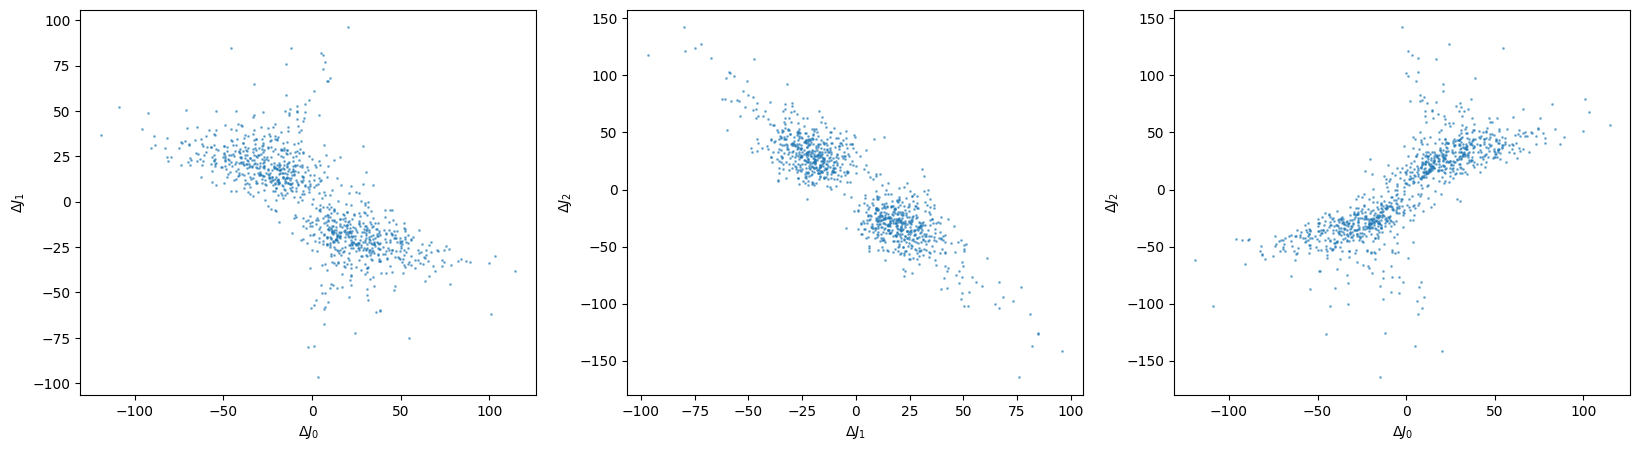

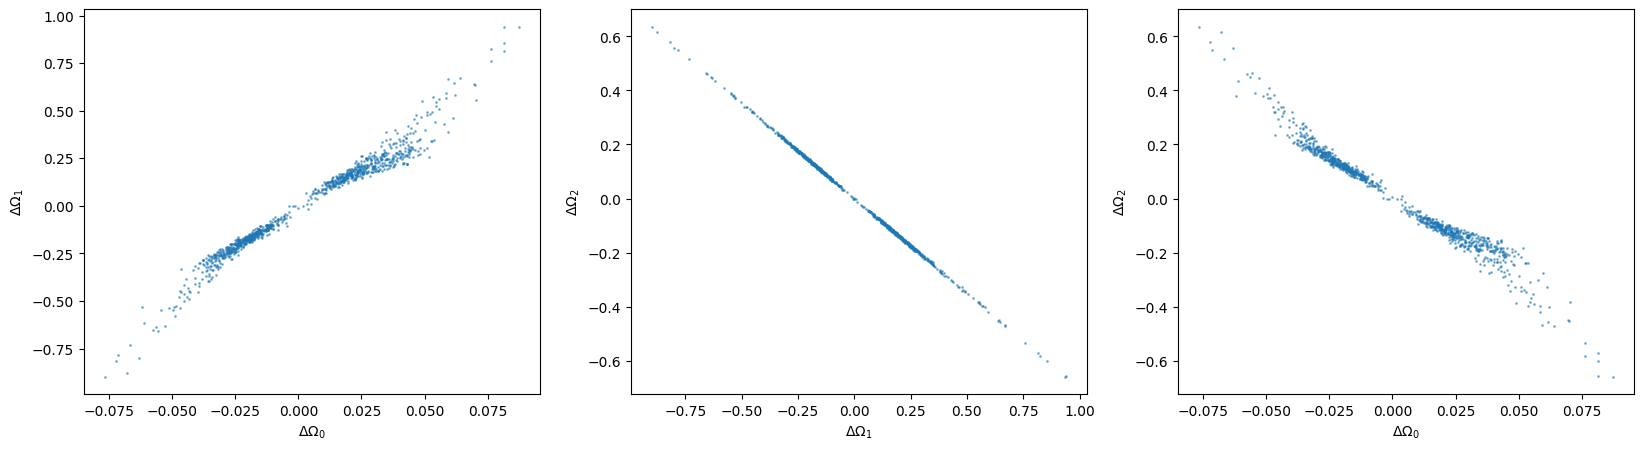

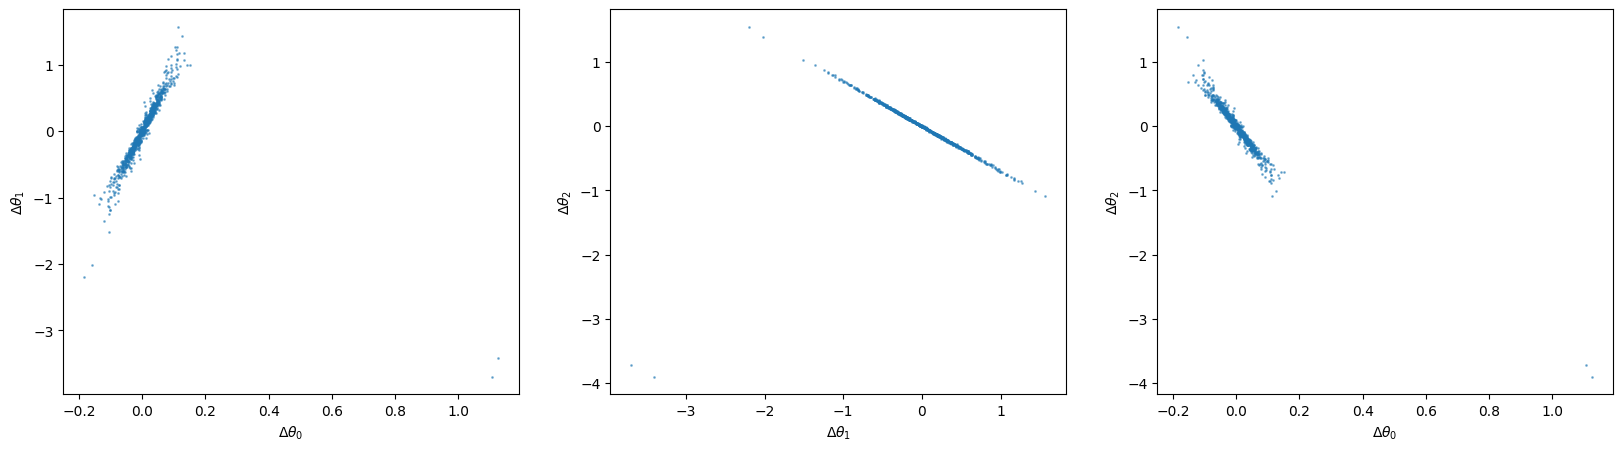

In [50]:
R_opt = rotation_matrix(*result['phi_hat'])

def rotate_actions_angles(J, Omega, theta, phi_hat):
    """
    Rotate actions, frequencies, and angles by the canonical transformation
    defined by rotation angles phi_hat = (phi_r, phi_phi, phi_z).
    
    Inputs:
        J, Omega, theta : arrays of shape (N, 3)
        phi_hat : tuple/list of 3 angles (φ_r, φ_φ, φ_z)
    
    Returns:
        J_rot, Omega_rot, theta_rot : rotated quantities
    """
    R = rotation_matrix(*phi_hat)   # Rr Rphi Rz as defined before
    
    # Apply rotation (matrix multiply on the right)
    J_rot = J @ R.T
    Omega_rot = Omega @ R.T
    theta_rot = theta @ R.T
    
    return J_rot, Omega_rot, theta_rot

J_rot, Omega_rot, theta_rot = rotate_actions_angles(actions, freqs, angles, result['phi_hat'])
J_rot_prog, Omega_rot_prog, theta_rot_prog = rotate_actions_angles(action_prog, freqs_prog, angles_prog, result['phi_hat'])


fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1, 3, 1)
ax.scatter(J_rot[:,0]-J_rot_prog[0], J_rot[:,1]-J_rot_prog[1], s=1, alpha=0.5)
ax.set_xlabel(r'$\Delta J_0$')
ax.set_ylabel(r'$\Delta J_1$')

ax = fig.add_subplot(1, 3, 2)
ax.scatter(J_rot[:,1]-J_rot_prog[1], J_rot[:,2]-J_rot_prog[2], s=1, alpha=0.5)
ax.set_xlabel(r'$\Delta J_1$')
ax.set_ylabel(r'$\Delta J_2$')

ax = fig.add_subplot(1, 3, 3)
ax.scatter(J_rot[:,0]-J_rot_prog[0], J_rot[:,2]-J_rot_prog[2], s=1, alpha=0.5)
ax.set_xlabel(r'$\Delta J_0$')
ax.set_ylabel(r'$\Delta J_2$')
plt.show()


fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1, 3, 1)
ax.scatter(Omega_rot[:,0]-Omega_rot_prog[0], Omega_rot[:,1]-Omega_rot_prog[1], s=1, alpha=0.5)
ax.set_xlabel(r'$\Delta \Omega_0$')
ax.set_ylabel(r'$\Delta \Omega_1$')

ax = fig.add_subplot(1, 3, 2)
ax.scatter(Omega_rot[:,1]-Omega_rot_prog[1], Omega_rot[:,2]-Omega_rot_prog[2], s=1, alpha=0.5)
ax.set_xlabel(r'$\Delta \Omega_1$')
ax.set_ylabel(r'$\Delta \Omega_2$')

ax = fig.add_subplot(1, 3, 3)
ax.scatter(Omega_rot[:,0]-Omega_rot_prog[0], Omega_rot[:,2]-Omega_rot_prog[2], s=1, alpha=0.5)
ax.set_xlabel(r'$\Delta \Omega_0$')
ax.set_ylabel(r'$\Delta \Omega_2$')
plt.show()

fig  = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1, 3, 1)
ax.scatter(theta_rot[:,0]-theta_rot_prog[0], theta_rot[:,1]-theta_rot_prog[1], s=1, alpha=0.5)
ax.set_xlabel(r'$\Delta \theta_0$')
ax.set_ylabel(r'$\Delta \theta_1$')

ax = fig.add_subplot(1, 3, 2)
ax.scatter(theta_rot[:,1]-theta_rot_prog[1], theta_rot[:,2]-theta_rot_prog[2], s=1, alpha=0.5)
ax.set_xlabel(r'$\Delta \theta_1$')
ax.set_ylabel(r'$\Delta \theta_2$')

ax = fig.add_subplot(1, 3, 3)
ax.scatter(theta_rot[:,0]-theta_rot_prog[0], theta_rot[:,2]-theta_rot_prog[2], s=1, alpha=0.5)
ax.set_xlabel(r'$\Delta \theta_0$')
ax.set_ylabel(r'$\Delta \theta_2$')
plt.show()

(-1.0, 1.0)

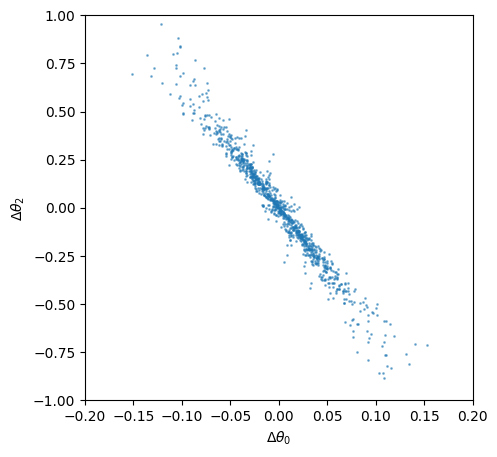

In [68]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1,1 )
ax.scatter(theta_rot[:,0]-theta_rot_prog[0], theta_rot[:,2]-theta_rot_prog[2], s=1, alpha=0.5)
ax.set_xlabel(r'$\Delta \theta_0$')
ax.set_ylabel(r'$\Delta \theta_2$')
plt.xlim(-0.2, 0.2)
plt.ylim(-1, 1)

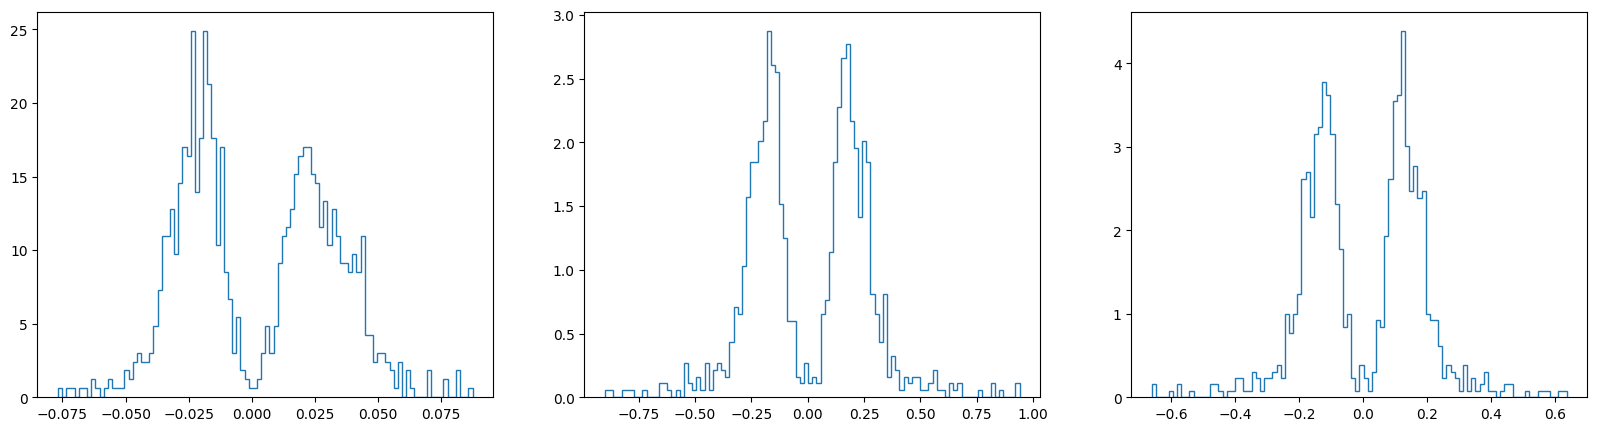

In [51]:
fig = plt.figure(figsize=(20, 5))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    ax.hist(Omega_rot[:,i] - Omega_rot_prog[i], bins=100, histtype='step', density=True)
    # ax.set_xlim(-1, 1)

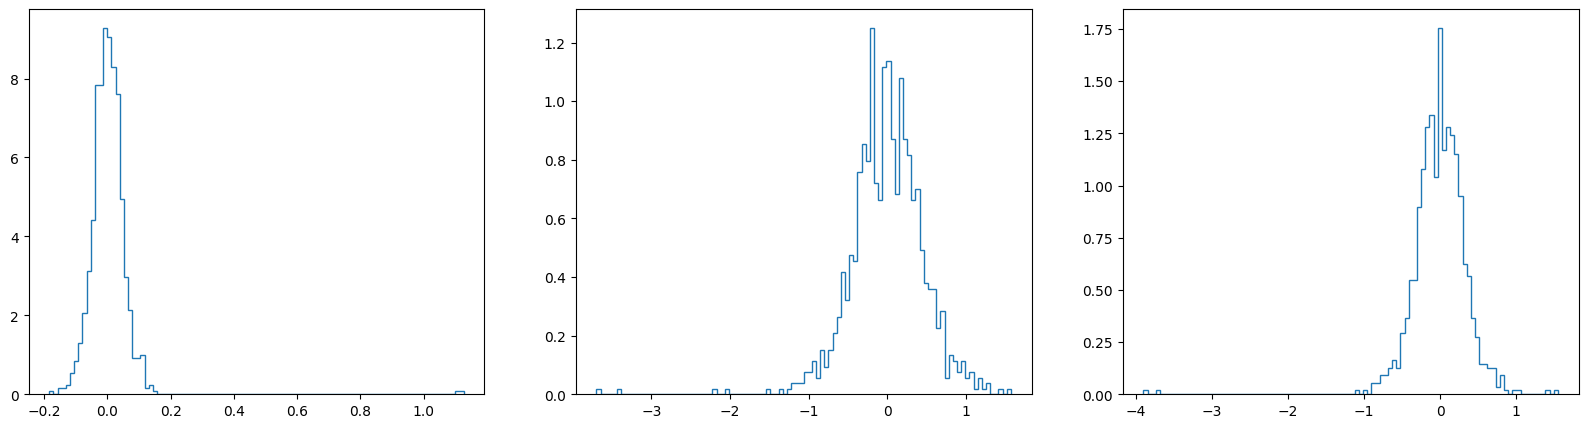

In [52]:
fig = plt.figure(figsize=(20, 5))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    ax.hist(theta_rot[:,i] - theta_rot_prog[i], bins=100, histtype='step', density=True)
    # ax.set_xlim(-1, 1)

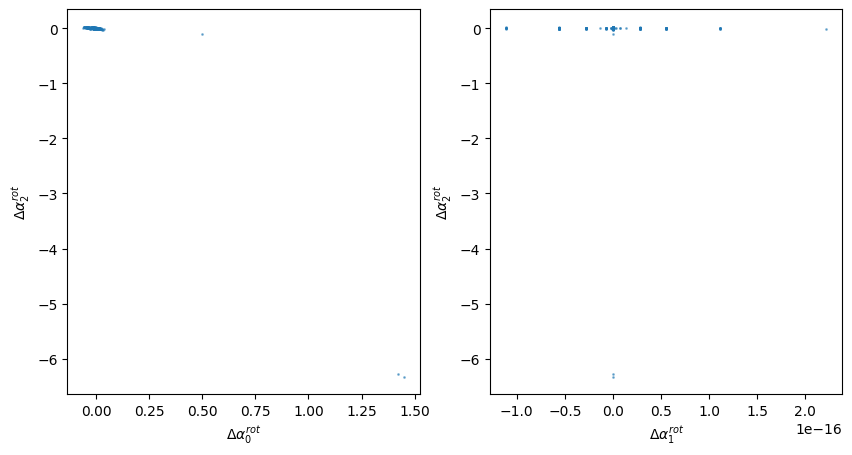

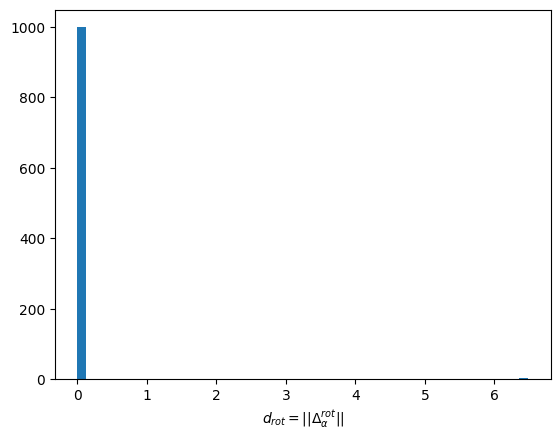

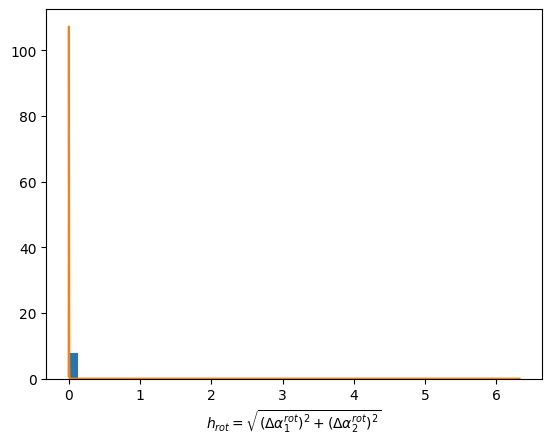

In [53]:
delta_theta_rot = theta_rot - theta_rot_prog
delta_Omega_rot = Omega_rot - Omega_rot_prog
delta_t_rot = delta_theta_rot[:, 1]/delta_Omega_rot[:, 1]
delta_alpha_rot = delta_theta_rot - delta_Omega_rot * delta_t_rot[:, None]
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121,)
ax.scatter(delta_alpha_rot[:,0], delta_alpha_rot[:,2], s=1, alpha=0.5)
ax.set_xlabel(r'$\Delta \alpha_0^{rot}$')
ax.set_ylabel(r'$\Delta \alpha_2^{rot}$')
ax = fig.add_subplot(122,)
plt.scatter(delta_alpha_rot[:,1], delta_alpha_rot[:,2], s=1, alpha=0.5)
plt.xlabel(r'$\Delta \alpha_1^{rot}$')
plt.ylabel(r'$\Delta \alpha_2^{rot}$')
plt.show()

d_rot = np.linalg.norm(delta_alpha_rot, axis=1)
plt.hist(d_rot, bins=50 );
plt.xlabel(r'$d_{rot} = ||\Delta_\alpha^{rot}||$')
plt.show()

h_rot = np.sqrt(delta_alpha_rot[:, 1]**2 + delta_alpha_rot[:, 2]**2)
plt.hist(h_rot, bins=50, density=True );
plt.xlabel(r'$h_{rot} = \sqrt{(\Delta \alpha_1^{rot})^2 + (\Delta \alpha_2^{rot})^2}$')
h_rot_sort = np.sort(h_rot)
sigma = 0.004
plt.plot(h_rot_sort,  h_rot_sort/sigma**2 * np.exp(-h_rot_sort**2/sigma**2))

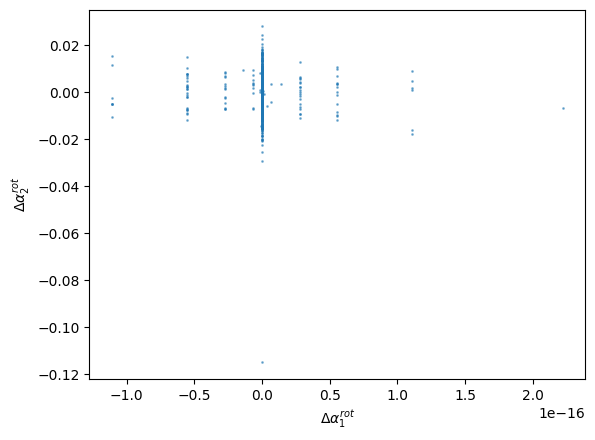

In [54]:
mask = d_rot < 1
plt.scatter(delta_alpha_rot[mask,1], delta_alpha_rot[mask,2], s=1, alpha=0.5)
plt.xlabel(r'$\Delta \alpha_1^{rot}$')
plt.ylabel(r'$\Delta \alpha_2^{rot}$')
plt.show()


In [55]:
delta_alpha_rot.shape

(1002, 3)

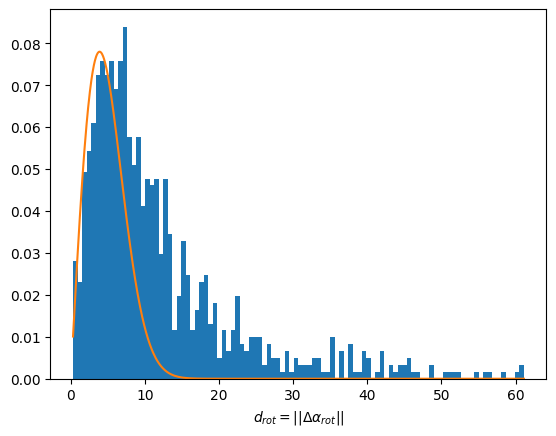

In [64]:

d_rot = np.linalg.norm(delta_alpha_rot, axis=1) * 1000
d_rot_plot = d_rot[d_rot<100]
# d_rot = d_rot[mask]
x = np.sort(d_rot_plot)
sigma = 5.5
plt.hist(x, density=True, bins=100);
plt.xlabel(r'$d_{rot} = ||\Delta \alpha_{rot}||$')
plt.plot(x,  x/sigma**2 * np.exp(-x**2/sigma**2))
plt.show()

# Gala

In [70]:
import gala.dynamics as gala_gd
import gala.integrate as gala_gi
import gala.potential as gala_gp
from gala.units import galactic
import astropy.units as u

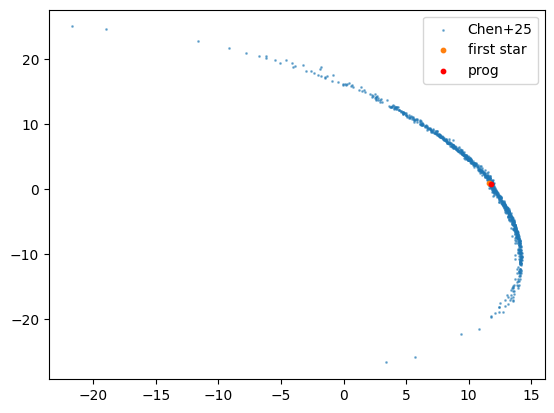

In [71]:
plt.scatter(stream_c25.q.x.value, stream_c25.q.y.value, s=1, label="Chen+25", alpha=0.5)
plt.scatter(stream_c25.q.x[0].value, stream_c25.q.y[0].value, s=10, label="first star", )
prog_c25_x = prog_c25.q.x.value
prog_c25_y = prog_c25.q.y.value
plt.scatter(np.array(prog_c25_x), np.array(prog_c25_y), s=10, label="prog", color='red')
plt.legend()

In [84]:
def stream_to_numpyarray(stream):
    pos = np.array([stream.q.x.to('kpc'), stream.q.y.to('kpc'), stream.q.z.to('kpc')])
    vel = np.array([stream.p.x.to('km/s'), stream.p.y.to('km/s'), stream.p.z.to('km/s')])
    return pos, vel
stream_array_pos, stream_array_vel = stream_to_numpyarray(stream_c25)

def prog_to_numpyarray(prog):
    pos = np.array([prog.q.x.to('kpc').value, prog.q.y.to('kpc').value, prog.q.z.to('kpc').value])
    vel = np.array([prog.p.x.to('km/s').value, prog.p.y.to('km/s').value, prog.p.z.to('km/s').value])
    return pos, vel


In [73]:
stream_array_pos, stream_array_vel = prog_to_numpyarray(prog_c25)

/export/home/vgiusepp/miniconda3/envs/galax/lib/python3.11/site-packages/gala/dynamics/core.py:163: AstropyDeprecationWarning: The get_name method is deprecated and may be removed in a future version.
        Use name instead.
  name = pos.__class__.get_name()

/export/home/vgiusepp/miniconda3/envs/galax/lib/python3.11/site-packages/gala/dynamics/orbit.py:949: AstropyDeprecationWarning: The get_name method is deprecated and may be removed in a future version.
        Use name instead.
  self.pos.get_name() == "cartesian"



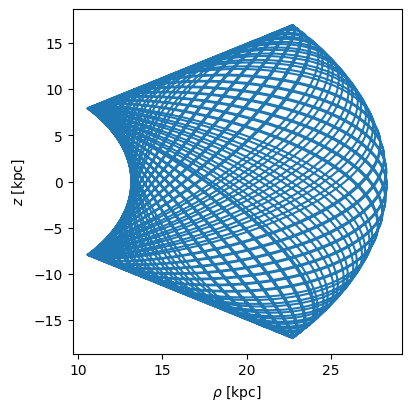

In [74]:
pot = gala_gp.MilkyWayPotential()
w0 = gala_gd.PhaseSpacePosition(pos=stream_array_pos * u.kpc, 
                                vel=stream_array_vel * u.km/u.s)
w = gala_gp.Hamiltonian(pot).integrate_orbit(w0, dt=0.5, n_steps=50000)
cyl = w.represent_as('cylindrical')
fig = cyl.plot(['rho', 'z'], linestyle='-') 

/export/home/vgiusepp/miniconda3/envs/galax/lib/python3.11/site-packages/gala/dynamics/core.py:321: AstropyDeprecationWarning: The get_name method is deprecated and may be removed in a future version.
        Use name instead.
  pos_name = new_pos if isinstance(new_pos, str) else new_pos.get_name()



Text(0, 0.5, '$J_1$ [rad]')

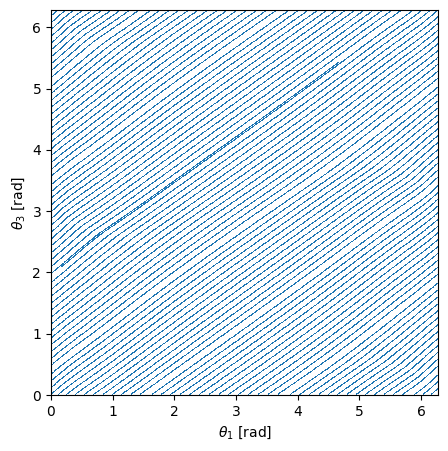

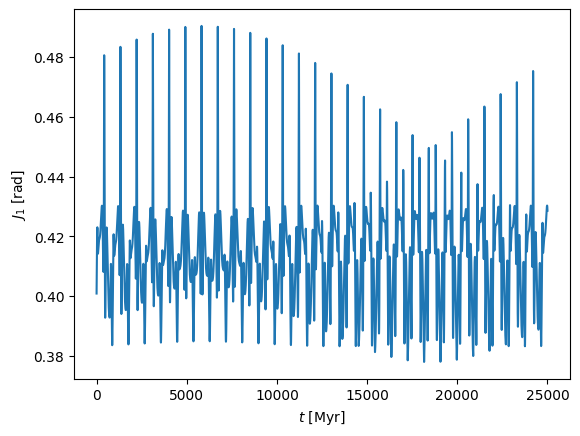

In [75]:
toy_potential = gala_gd.fit_isochrone(w)
toy_actions,toy_angles,toy_freqs = toy_potential.action_angle(w)
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(toy_angles[0], toy_angles[2], linestyle='none', marker=',') 
ax.set_xlim(0,2*np.pi) 
ax.set_ylim(0,2*np.pi) 
ax.set_xlabel(r"$\theta_1$ [rad]") 
ax.set_ylabel(r"$\theta_3$ [rad]") 

fig,ax = plt.subplots(1,1)
ax.plot(w.t, toy_actions[0], marker='') 
ax.set_xlabel(r"$t$ [Myr]") 
ax.set_ylabel(r"$J_1$ [rad]") 


In [76]:
result = gala_gd.find_actions_o2gf(w, N_max=8, toy_potential=toy_potential) 
result['actions'].to(u.kpc*u.km/u.s)

/export/home/vgiusepp/miniconda3/envs/galax/lib/python3.11/site-packages/gala/dynamics/core.py:321: AstropyDeprecationWarning: The get_name method is deprecated and may be removed in a future version.
        Use name instead.
  pos_name = new_pos if isinstance(new_pos, str) else new_pos.get_name()

/export/home/vgiusepp/miniconda3/envs/galax/lib/python3.11/site-packages/gala/dynamics/core.py:163: AstropyDeprecationWarning: The get_name method is deprecated and may be removed in a future version.
        Use name instead.
  name = pos.__class__.get_name()

/export/home/vgiusepp/miniconda3/envs/galax/lib/python3.11/site-packages/gala/dynamics/core.py:321: AstropyDeprecationWarning: The get_name method is deprecated and may be removed in a future version.
        Use name instead.
  pos_name = new_pos if isinstance(new_pos, str) else new_pos.get_name()

/export/home/vgiusepp/miniconda3/envs/galax/lib/python3.11/site-packages/gala/dynamics/actionangle/actionangle_o2gf.py:652: UserWarning:

<Quantity [[  403.47605953, -3089.60080744,   808.5705163 ]] km kpc / s>

nvecs shape: (256, 3)
result['Sn'] shape: (1, 256)
toy_angles shape: (3, 50001)


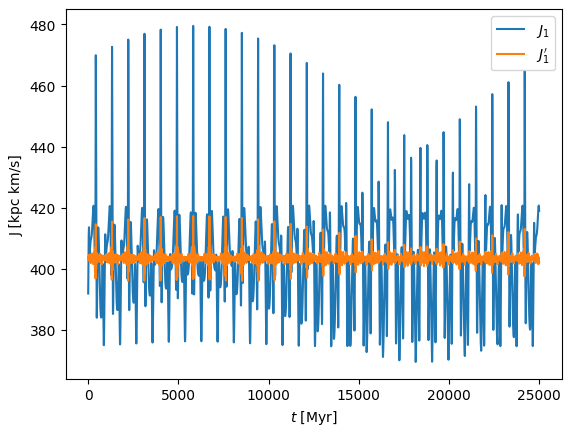

In [77]:
nvecs = gala_gd.generate_n_vectors(8, dx=1, dy=2, dz=2) 


# Check shapes for debugging
print(f"nvecs shape: {nvecs.shape}")
print(f"result['Sn'] shape: {result['Sn'].shape}")
print(f"toy_angles shape: {toy_angles.shape}")

# Correct broadcasting:
# nvecs: (256, 3) - frequency vectors
# result['Sn']: (3, 256) - action coefficients
# toy_angles: (3, 20001) - angles over time
# nvecs.dot(toy_angles): (256, 20001) - phase for each frequency vector at each time

# Calculate phase for each frequency vector
phases = nvecs.dot(toy_angles)  # shape: (256, 20001)

# Calculate correction for each action component
# nvecs.T: (3, 256) - frequency components for each action
# result['Sn']: (3, 256) - coefficients
# cos(phases): (256, 20001) - time evolution

act_correction = nvecs.T[:, :, None] * result['Sn'][:, :, None] * np.cos(phases)[None, :, :]
# Shape: (3, 256, 20001)

# Sum over frequency vectors (axis=1) to get total correction
action_approx = toy_actions - 2*np.sum(act_correction, axis=1)*u.kpc**2/u.Myr 
# Shape: (3, 20001)

fig,ax = plt.subplots(1,1) 
ax.plot(w.t, toy_actions[0].to(u.km/u.s*u.kpc), marker='', label='$J_1$') 
ax.plot(w.t, action_approx[0].to(u.km/u.s*u.kpc), marker='', label="$J_1'$") 
ax.set_xlabel(r"$t$ [Myr]") 
ax.set_ylabel(r"J [kpc km/s]")  # Fixed unit label
ax.legend()
# plt.savefig('./plot/particlespray_chen25/action_correction_J1.png', dpi=300, bbox_inches='tight')
plt.show()



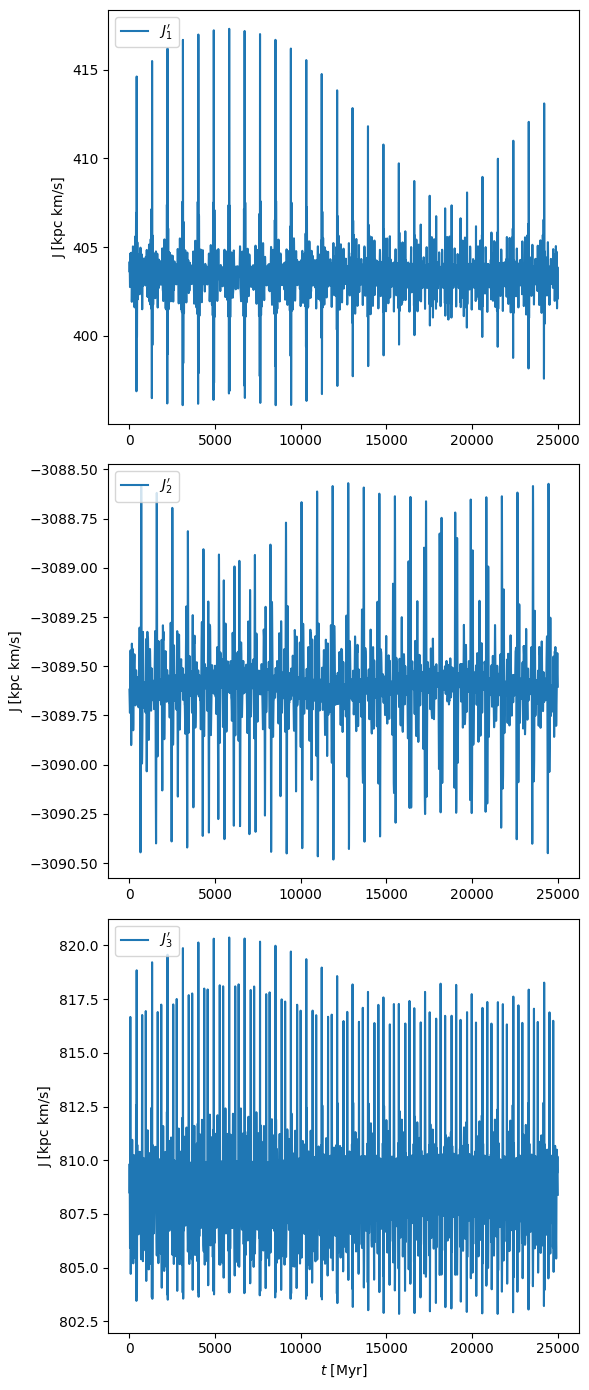

In [81]:
# for visualization, compute the action correction used to transform the
#   toy potential actions to the approximate true potential actions
nvecs = gala_gd.generate_n_vectors(8, dx=1, dy=2, dz=2)

# Recalculate phases with the new nvecs
phases = nvecs.dot(toy_angles)  # shape: (256, 20001)

# Now the broadcasting will work correctly
# act_correction = nvecs.T[:, :, None] * result['Sn'][:, :, None] * np.cos(phases)[None, :, :]
act_correction = nvecs.T[...,None] * result['Sn'][0][None,:,None] * np.cos(nvecs.dot(toy_angles))[None]
action_approx = toy_actions - 2*np.sum(act_correction, axis=1)*u.kpc**2/u.Myr

fig,axes = plt.subplots(3,1,figsize=(6,14))

for i,ax in enumerate(axes):
    # ax.plot(w.t, toy_actions[i].to(u.km/u.s*u.kpc), marker='', label='$J_{}$'.format(i+1))
    ax.plot(w.t, action_approx[i].to(u.km/u.s*u.kpc), marker='', label="$J_{}'$".format(i+1))
    ax.set_ylabel(r"J [kpc km/s]")  # Fixed unit label
    ax.legend(loc='upper left')

ax.set_xlabel(r"$t$ [Myr]")
fig.tight_layout()
plt.show()

# Galpy

In [85]:
from gala.dynamics.actionangle import get_staeckel_fudge_delta
from galpy.actionAngle import actionAngleStaeckel

w0 = gala_gd.PhaseSpacePosition(pos=stream_array_pos * u.kpc, 
                                    vel=stream_array_vel * u.km/u.s)
orbits = pot.integrate_orbit(
    w0, dt=0.5, n_steps=20000)
galpy_potential = pot.as_interop("galpy")
J = np.zeros((3, orbits.norbits))
Omega = np.zeros((3, orbits.norbits))
for n, orbit in enumerate(orbits.orbit_gen()): 
    o = orbit.to_galpy_orbit()
    delta = get_staeckel_fudge_delta(pot, orbit)
    staeckel = actionAngleStaeckel(pot=galpy_potential, delta=delta)
    af = staeckel.actionsFreqs(o)
    af = np.mean(np.stack(af), axis=1)
    J[:3, n] = af[:3]
    Omega[:3, n] = af[3:]

/export/home/vgiusepp/miniconda3/envs/galax/lib/python3.11/site-packages/gala/dynamics/core.py:163: AstropyDeprecationWarning: The get_name method is deprecated and may be removed in a future version.
        Use name instead.
  name = pos.__class__.get_name()



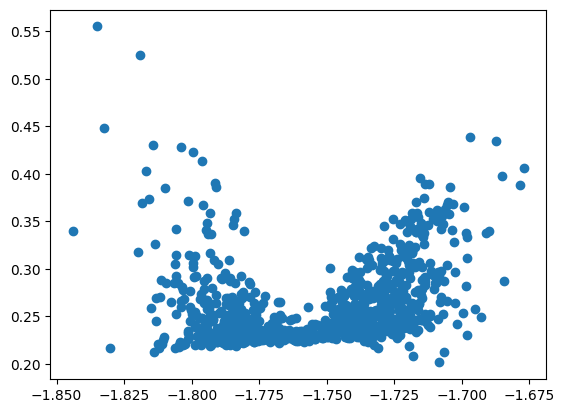

In [86]:
plt.scatter(J[1], J[0]) 

In [87]:
stream_array_pos

array([[11.646393  , 11.7708435 , 12.690392  , ..., 11.900373  ,
        11.644862  , 11.967012  ],
       [ 0.9689124 ,  0.9297569 , -1.7764776 , ...,  0.8035314 ,
         0.78578013,  0.8073465 ],
       [ 6.4686    ,  6.532347  ,  5.4448295 , ...,  6.4651856 ,
         6.3008723 ,  6.475597  ]], shape=(3, 1002), dtype=float32)